# Figure 6a and 6b
## As Fig 5, but without the ABCDE particle
## Use the second plot from do_recall_Ps(2.5, evolution(0.75))
## The first plot doesn't have anything not already in Fig 5.

Updated 19-12-2024 to work properly with the latest matplotlib 

evolution() creates the plots of the evolution of particle Ps
and the normalised LTM Ps.

To use different particle sequences change:
column_titles = ['ABCDE', 'ADCEB', 'ABDCE', 'LTM'] 
The input and recalled sequence is always ABCDE.

do_recall_Ps() creates the STM, LTM, Recall Ps plots


Create plots with 'Run all'





In [75]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

decay = 0.7
num_cols = 5 # set in evolution anyway
labels = ['A','B','C','D','E']
xtick_locations = [0,1,2,3,4]
ytick_locations = [0.2,0.4,0.6,0.8]

In [76]:
# This is the thurstone (softmax) procedure from the PF progs
# returns array of Ps
def np_thurstone_sd(inp, sd):
    out = np.zeros(len(inp))
    exps = np.zeros(len(inp))
    # need this to make actual SD do the right thing in Luce
    luce_noise = math.sqrt(2.0)/sd

    for i, val in enumerate(inp):
        if val > 0.0:  # ignore the suppressed -infs
            exps[i] = math.exp(luce_noise * val)
        else:
            exps[i] = 0.0
    sum_exps = sum(exps)
    out = exps/sum_exps

    return out


In [77]:
'''
converts letter strings e.g. 'BADCE' to gradients 
'''

def l2g(input):
    letters = 'ABCDE'
    gradient = np.zeros(len(letters))
    
    for i, val in enumerate(input):
        gradient[letters.index(val)] = len(input) - i
        
    return(gradient)
    

In [78]:
# Combination of STM and LTM (as original fig 6)

def do_recall_Ps(sigma, all_probies):
    n_sequences = 3
    gradient = np.array([5,4,3,2,1]) # this determines the order that the particle represents
    decay = 0.8
    STM_ps = np.zeros((n_sequences,5,5))
    posns = [0,1,2,3,4]
    n_posns = len(posns)
    column_titles = ['STM', 'LTM', 'Recall probabilities']    
    num_cols = len(column_titles)
    '''
    num_cols here refers to the number of cols in the evolution plot!
    STM_ps[] goes STM, LTM, Recall Ps
    '''
    

    # first do straightforward STM with decay
    for posn in range(n_posns):
        STM_ps[0,posn] = np_thurstone_sd(gradient,sigma)
        gradient = gradient * decay # do decay 
        gradient[posn] = 0 # suppress item
        #STM_ps[1,posn] = all_probies[num_cols -1, posn] # this comes from running the 
                                                        # evolution of particle probabilities
                                                        # cell above. Make sure it was run with sigma = 1.0
                                                        # This will be so if it's done 'Run all'
        
        STM_ps[1,posn] = all_probies[num_cols, posn]
        
        STM_ps[2,posn] = (STM_ps[0,posn] * STM_ps[1,posn])
        STM_ps[2,posn] /= STM_ps[2,posn].sum()
    
    '''
    print('STM_ps[1]\n',STM_ps[1])
    print('all_probies[num_cols -1]\n',all_probies[num_cols])  
    '''
    
    
    # now we have all of the data we can make the plots
    fig, ax = plt.subplots(5,3,figsize=(17,15))
    for col in range(3):  
        for posn in range(n_posns):
            ax[posn,col].set_ylim(0,1)
            
            if posn < n_posns-1:
                ax[posn,col].set_xticks(xtick_locations, [])             
            else: # only put ticklabels on the bottom row
                ax[posn,col].set_xticks(xtick_locations,labels)  
                
            if posn == 0: # titles only at the top
                ax[posn,col].set_title(column_titles[col])   
        
            if col == 0: # y-axis labels only on LHS
                ax[posn,col].set_ylabel(labels[posn], rotation='horizontal')
                ax[posn,col].yaxis.labelpad = 15
            else:
                ax[posn,col].set_yticks(ytick_locations, [])
        
            ax[posn,col].bar(np.arange(len(STM_ps[col,posn])),STM_ps[col,posn], color='black')


    plt.show()

    
    

I'm picking the conditional out from all_probies[col][posn][0]) which s zero after the first posn

In [79]:
# evolution of particle probabilities
def evolution(sigma):

    gradient = np.array([5,4,3,2,1]) # this determines the order that the particle represents
    posns = [0,1,2,3,4]
    n_posns = len(posns)
    column_titles = ['ABCED','BACDE', 'EBCDA', 'LTM'] 
    num_cols = len(column_titles)
    #all_gradients = np.array([l2g('ABCDE'), l2g('ABCED'), l2g('BACDE'), l2g('EBCDA')])
    all_gradients = np.array([l2g(column_titles[0]), l2g(column_titles[1]), l2g(column_titles[2])])                
    blank = ['','','','','',]
    print(all_gradients)
    

    
    # num_cols are the colums in the plots
    # the first 3 cols in the plots are particles, each with 5 input positions and 5 items
    # the last col is normalised Ps over cols/particles.
    conditional_ps = np.full((num_cols,5),1.0)
    prev_conditional_p = 1.0
    all_probies = np.zeros((num_cols, 5, 5)) # xxxxxx
                        
    fig, ax = plt.subplots(5,num_cols,figsize=(17,15))

    # first get the conditional Ps for all of the particles on the assumption
    # that the recalled sequence is ABCDE
    for col in range(num_cols -1): # don't do the last col a that's for the normalised Ps
        prev_conditional_p = 1.0
        for posn in range(len(gradient)): # posn is recall position NOT item at a particular recall
            # this is the Ps over output items for this position in the input
            '''
            This does softmax over the gradient of the particle.
            Below we suppress the 'activation' of the recalled item
            in the gradient.
            The conditional P is the P that that particle 'recalls'
            the items so far in the specified order (ABCDE).
            Note that because there is noise, even the conditional P of
            recalling the correct item goes down over the course of the list.
            We then multiply the Ps by the conditional P of recalling.
            '''
            
            
            '''
            Let's spell this out.
            Posn 0.
            do softmax for all
            Sum at each position and normalise - this is the LTM
            for each item record the conditional P of recalling that item
            posn 1.
            Do softmax again without the recalled item
            Multiply by conditional P of that particle having recalled the
            list in the specified order up to that point
            
            '''
            all_probies[col, posn] = np_thurstone_sd(all_gradients[col], sigma)
            conditional_ps[col,posn] = prev_conditional_p # Starts at 1.0. record the conditional ps for this col/posn
            prev_conditional_p *= all_probies[col][posn][posn]
            '''
            print('col',col, 'posn', posn)
            print('all_probies', all_probies)
            print('conditional_ps',conditional_ps)
            '''
            all_gradients[col,posn] = 0 # suppress item
        
    # now we get the normalised Ps representing the LTM priors 
    # normalise the 4 particle Ps and create the summed and normalised LTM
    # we're normalising across cols at each posn
    for posn in range(len(gradient)): # posn is recall position NOT item at a particular recall
        for col in range(num_cols -1): # don't do the last col as that's for the normalised Ps
            all_probies[col,posn] *= conditional_ps[col,posn]
            # Now we should have the softmax Ps * conditional Ps for each particle.
            # So we sum over positions and normalise
            
            # this is summing over the positions, so where we're looking at the initial gradients
            # that's just what comes back from the softmax, which is necessarily 1.0
            # sums to 1.0 at the first posn.
            
        tmp = all_probies[ : , posn]
        # and stick the normalised Ps into the last LTM col
        all_probies[num_cols -1, posn] = tmp.sum(0)/tmp.sum()
    
                    
    # now we have all of the data we can make the plots
    for col in range(num_cols):  
        for posn in range(len(gradient)):
            ax[posn,col].set_ylim(0,1)
            
            if posn < n_posns-1:
                ax[posn,col].set_xticks(xtick_locations, [])             
            else: # only put ticklabels on the bottom row
                ax[posn,col].set_xticks(xtick_locations,labels)  
                
            if posn == 0: # titles only at the top
                ax[posn,col].set_title(column_titles[col])   
        
            if col == 0: # y-axis labels only on LHS
                ax[posn,col].set_ylabel(labels[posn], rotation='horizontal')
                ax[posn,col].yaxis.labelpad = 15
            else:
                ax[posn,col].set_yticks(ytick_locations, [])
        
            ax[posn,col].bar(np.arange(len(all_probies[col,posn])),all_probies[col,posn], color='black')
            '''
            print('\n*** col', col, 'posn', posn)
            print(all_probies[col,posn])
            '''
                  
    plt.show()
    return (all_probies)
    

[[5. 4. 3. 1. 2.]
 [4. 5. 3. 2. 1.]
 [1. 4. 3. 2. 5.]]


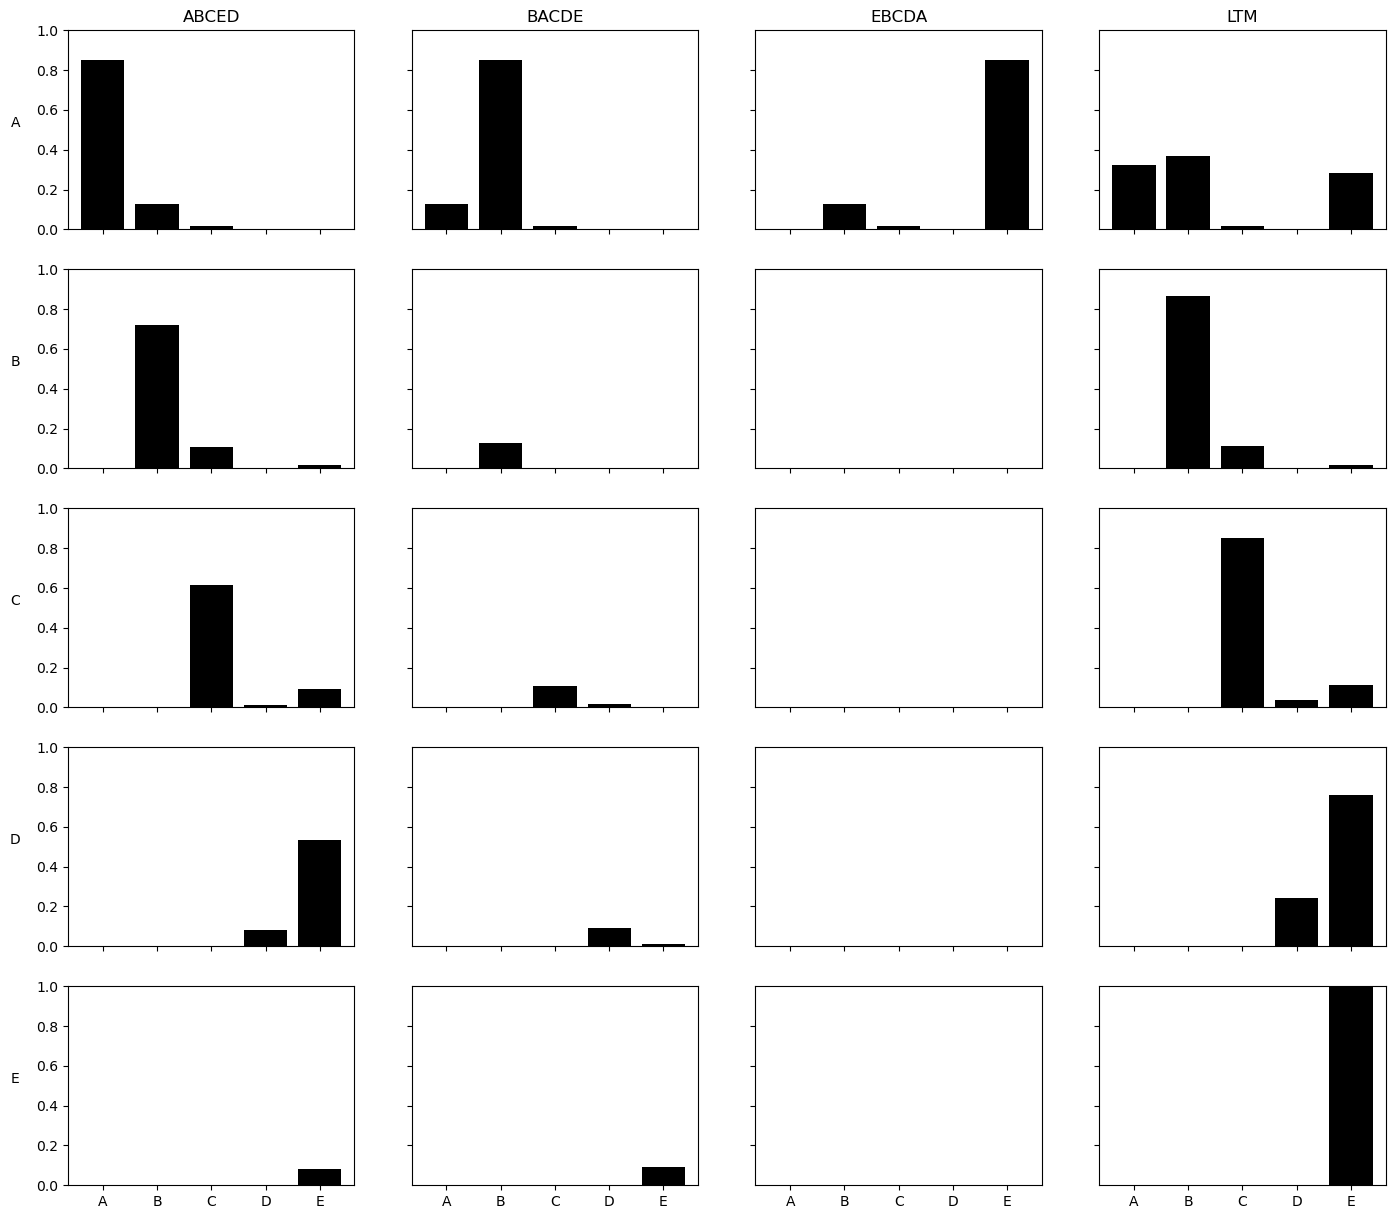

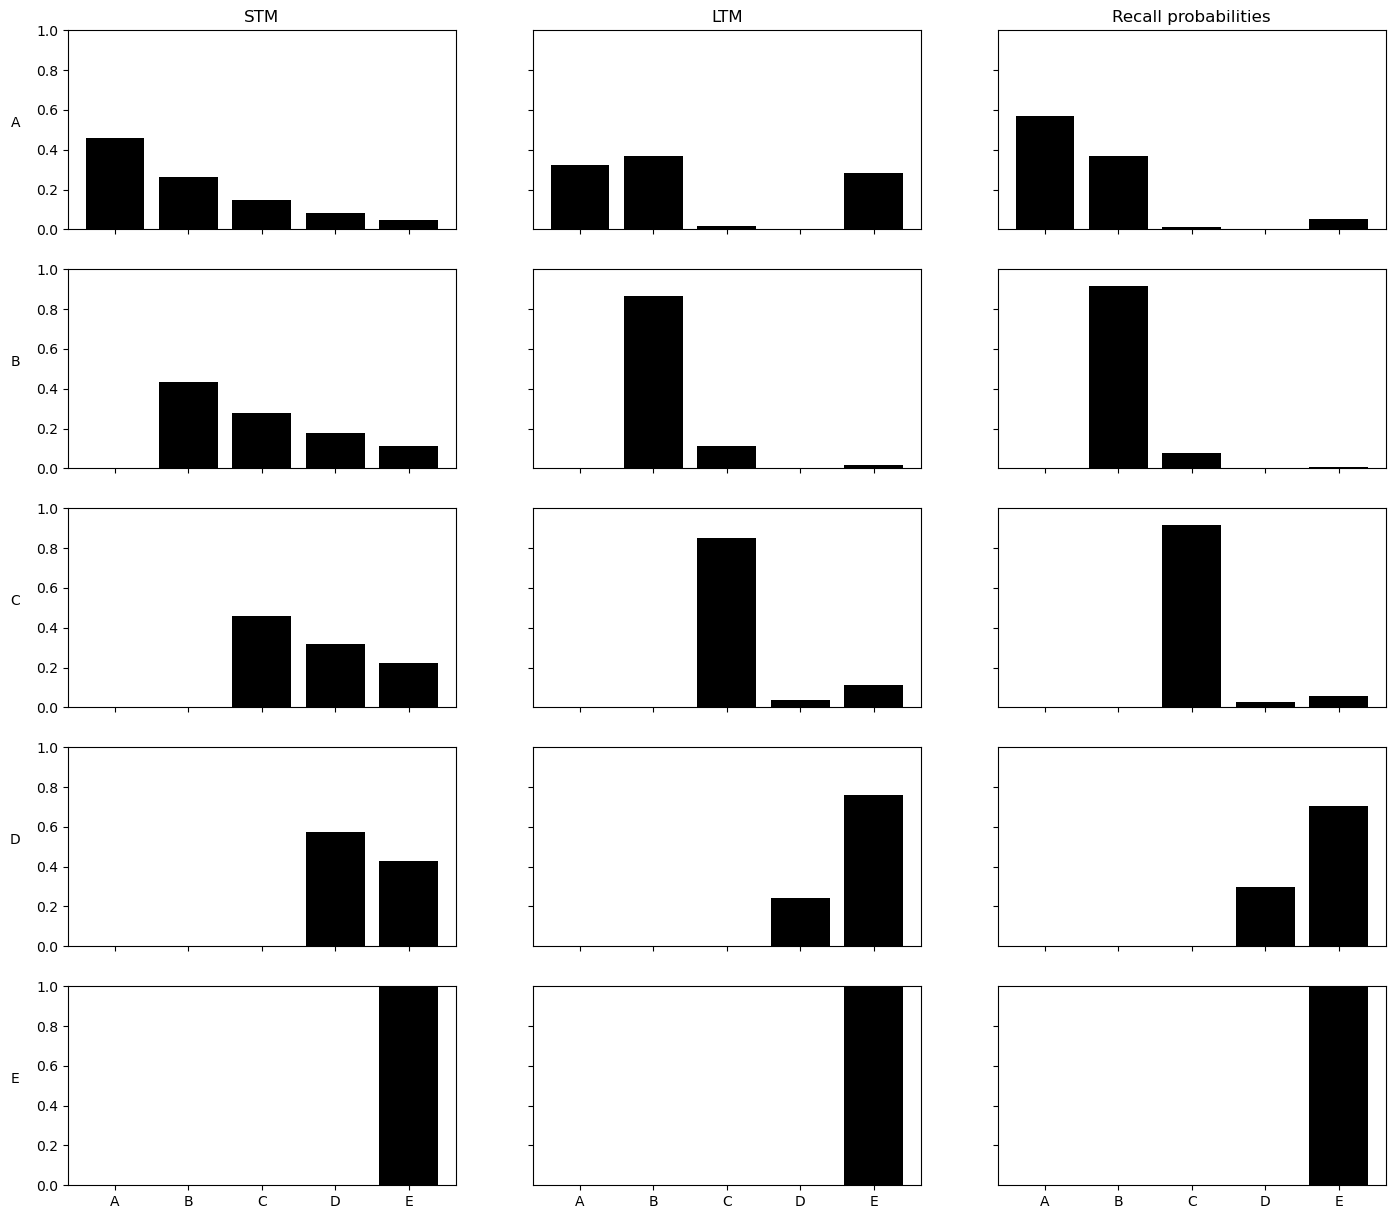

[[5. 4. 3. 1. 2.]
 [4. 5. 3. 2. 1.]
 [1. 4. 3. 2. 5.]]


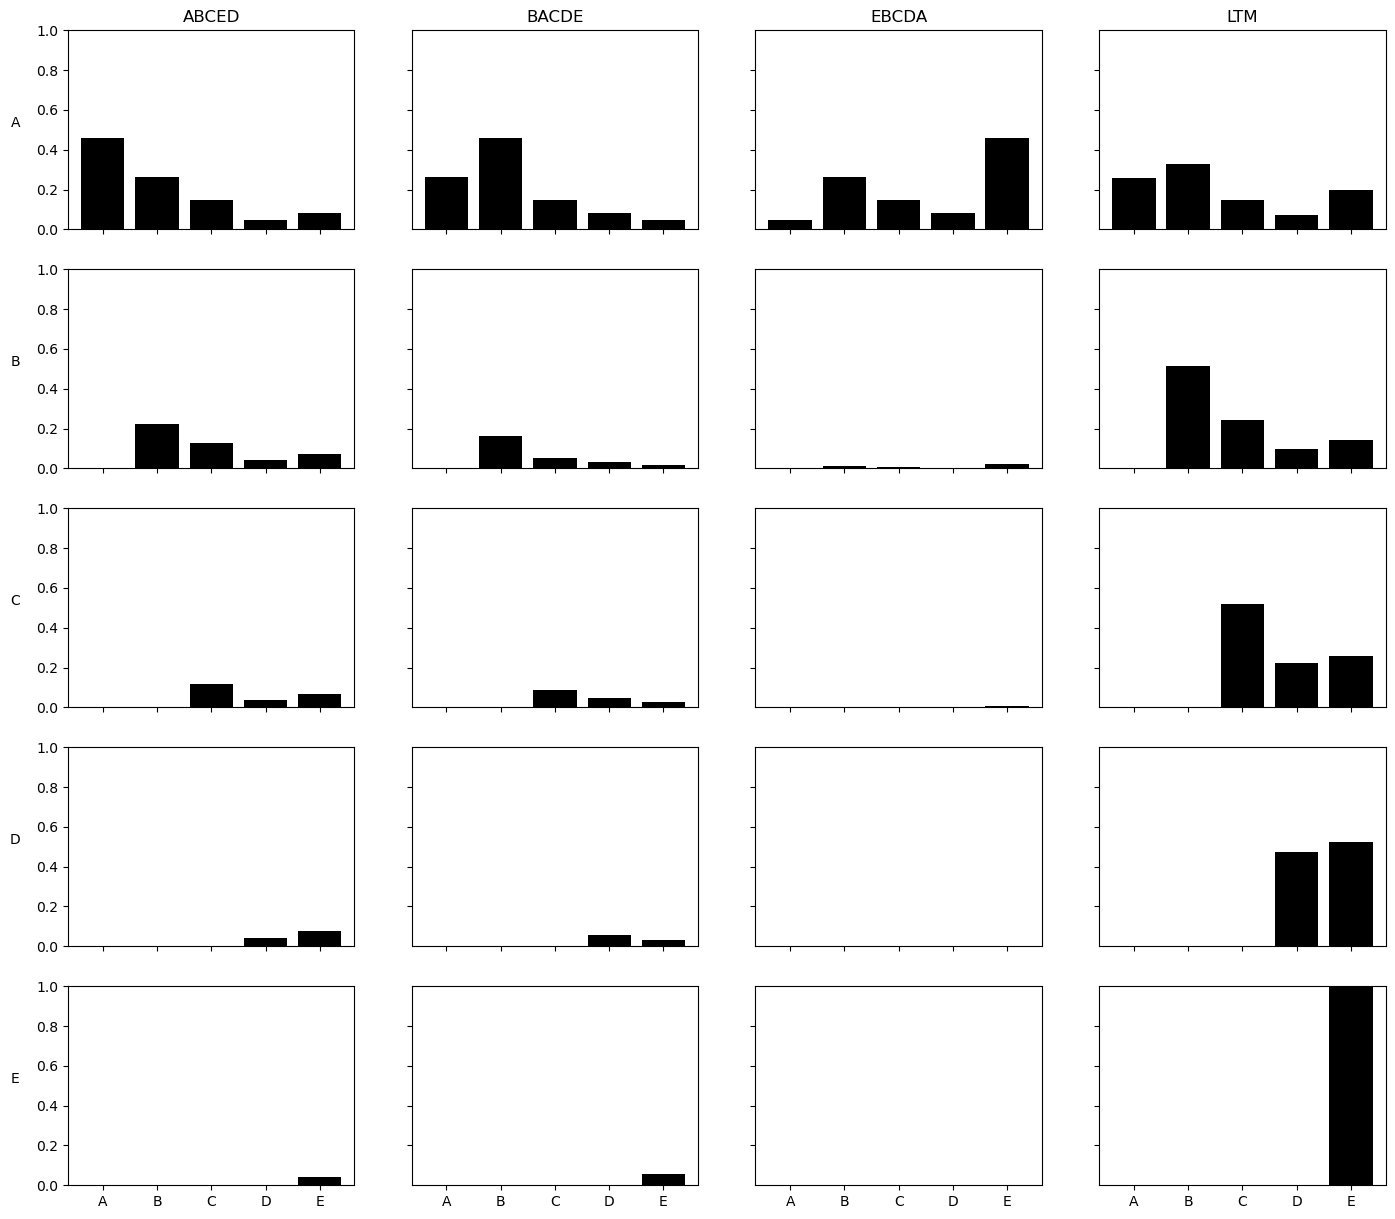

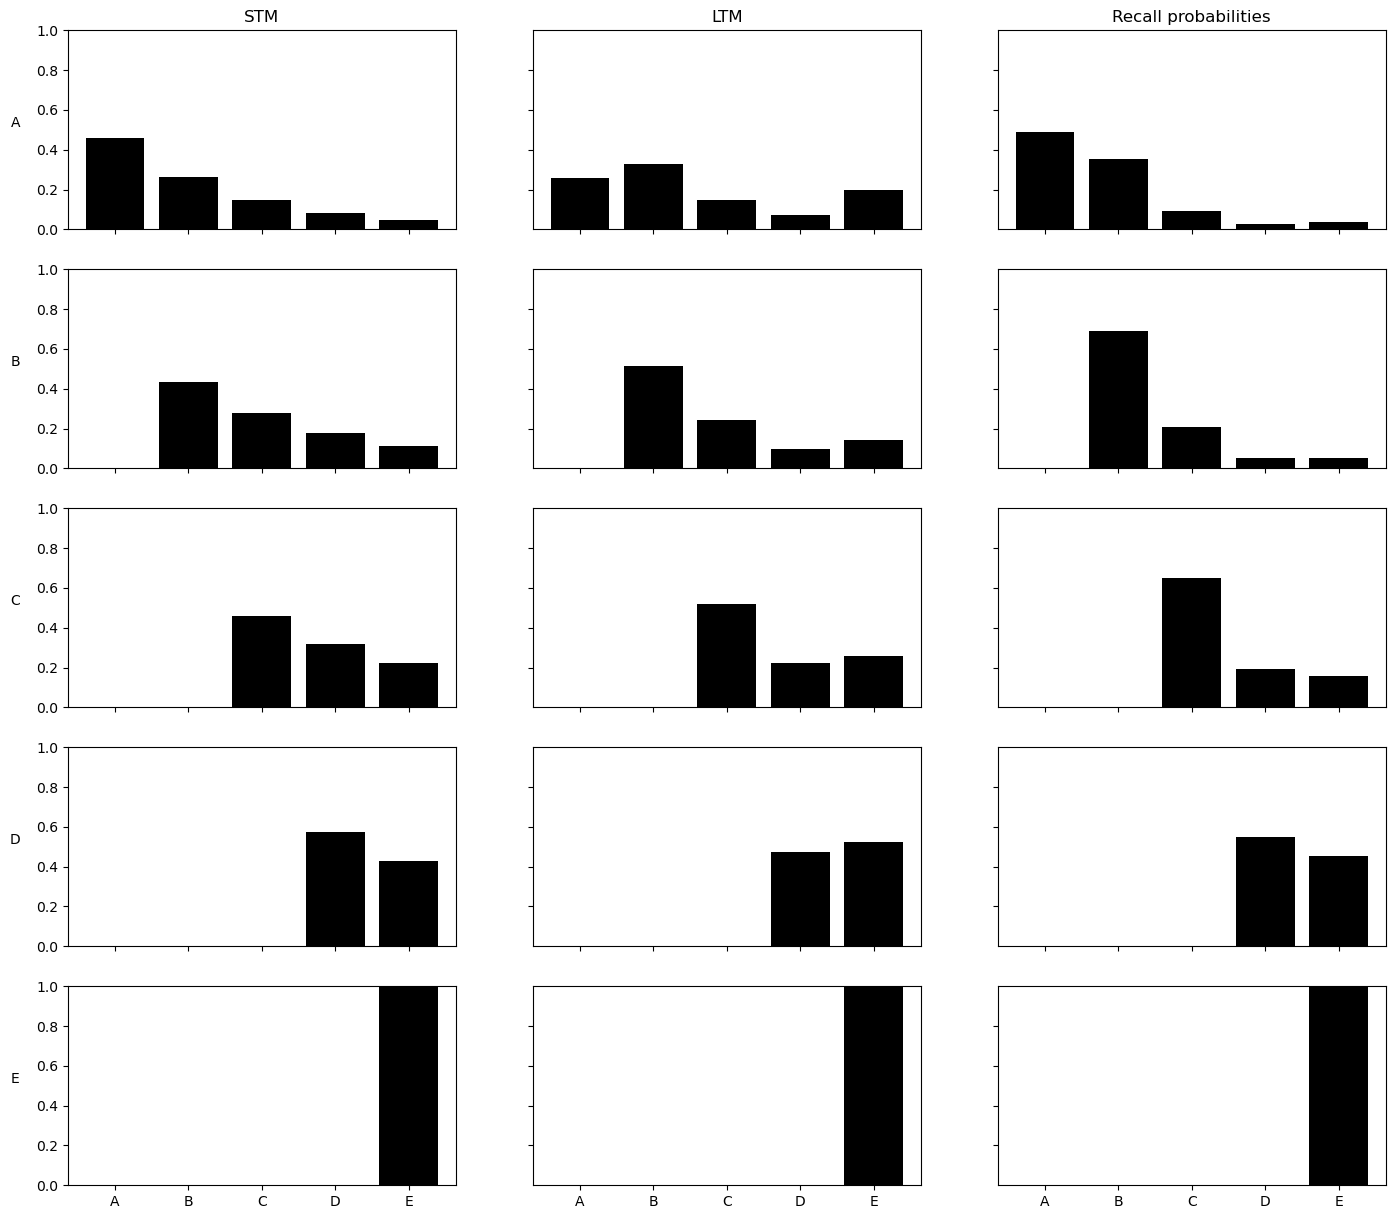

[[5. 4. 3. 1. 2.]
 [4. 5. 3. 2. 1.]
 [1. 4. 3. 2. 5.]]


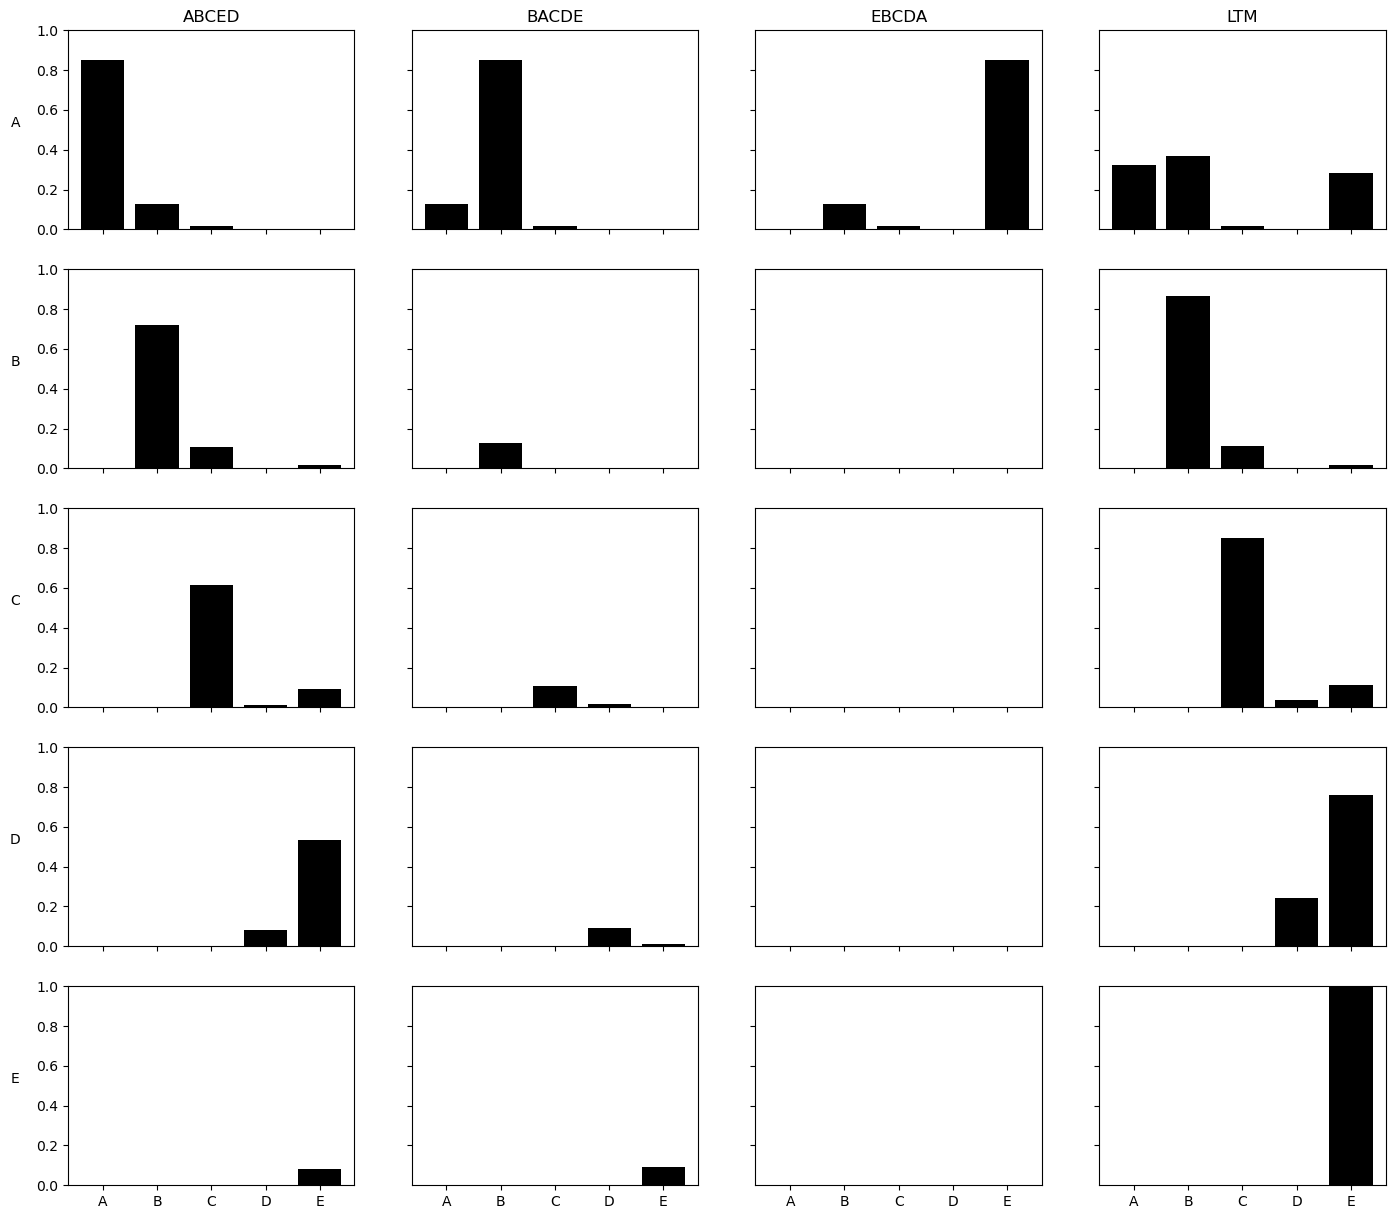

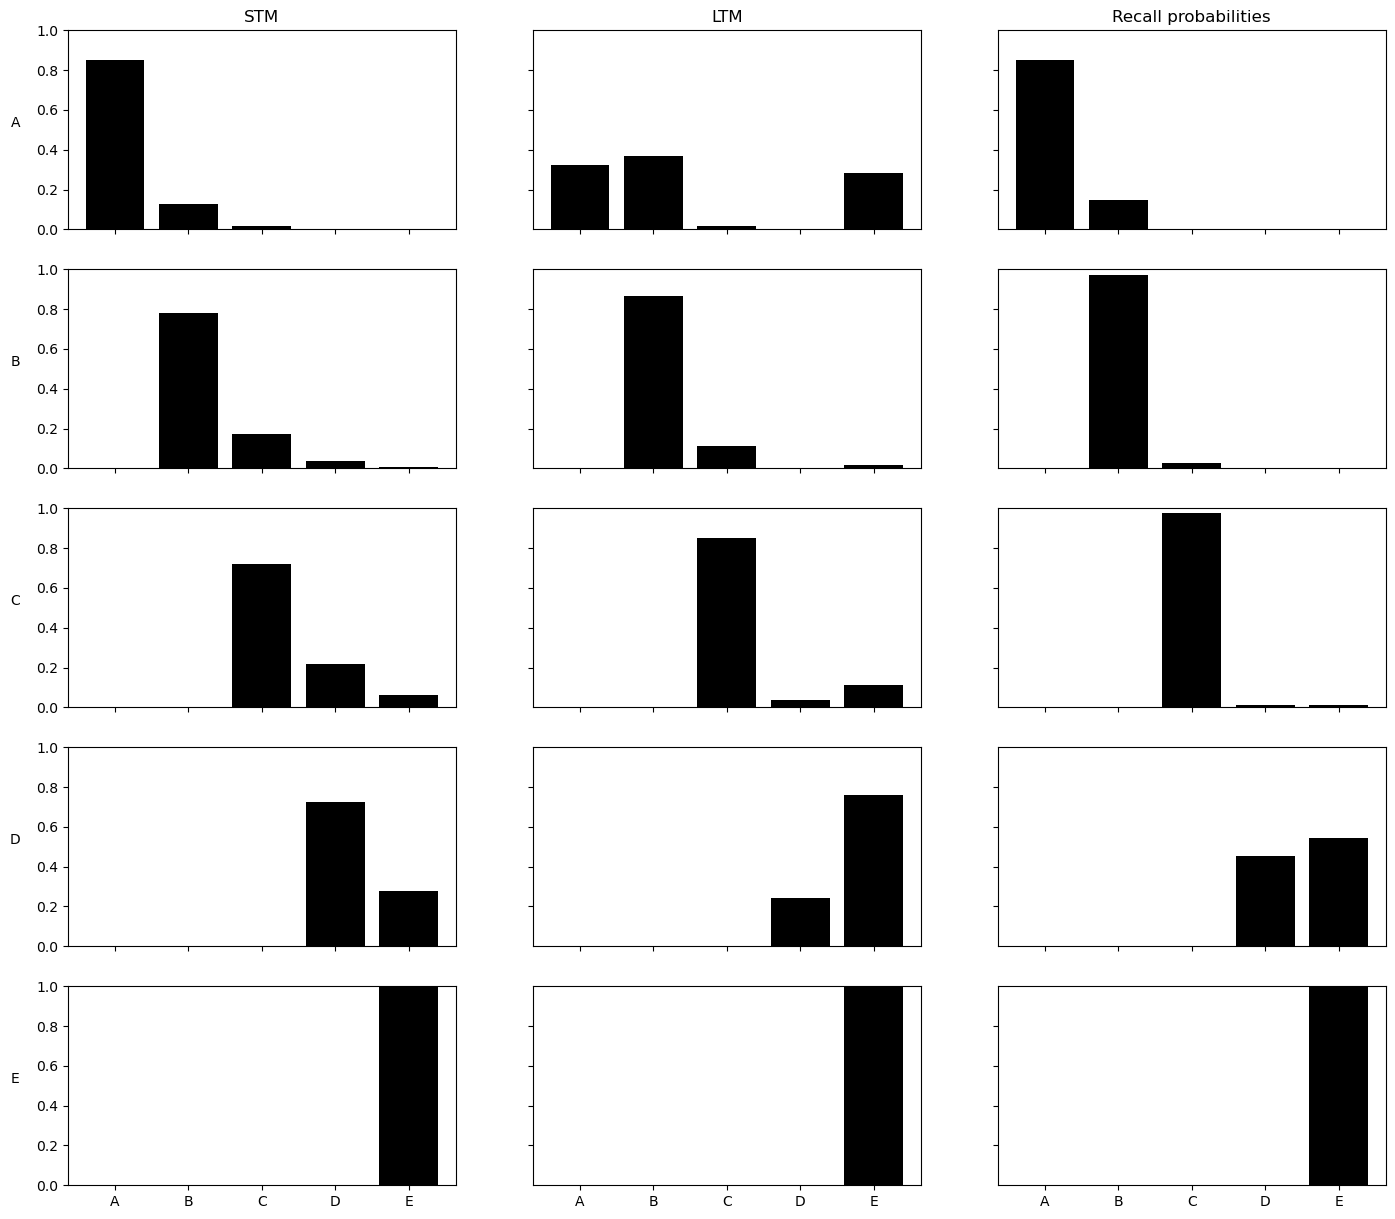

In [81]:

do_recall_Ps(2.5, evolution(0.75))
do_recall_Ps(2.5, evolution(2.5))
do_recall_Ps(0.75, evolution(0.75))
